
# Telco Customer Churn Prediction — Full Notebook
**Structure:** This notebook follows the project plan: topic, data description, preprocessing, target construction, feature construction, collinearity analysis, model specification, estimation, selection, CV, predictions, CIs, comparison, and policy recommendations.



In [1]:
# --- 0) Setup
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
from scipy.stats import ttest_ind, chi2_contingency


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report, confusion_matrix, brier_score_loss, log_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
import xgboost as xgb

import os
import kagglehub


## 1) Topic and Motivation
Predict customer churn (binary outcome) to help telecom reduce customer attrition. Predicting churn enables targeted retention, reducing acquisition costs and preserving revenue.

In [2]:
# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /Users/sedjrokoffiromulusakonakpo/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [3]:
os.listdir(path)
file_path = os.path.join(path, "WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = pd.read_csv(file_path)
print('Dataset shape:', df.shape)
df.head()


Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


There is no missing value. Then, we have another type problem. Many of the variables are `object` type. Which is not the convenient type. 

In [5]:
d = {k:"string" for k in df.columns}
d

{'customerID': 'string',
 'gender': 'string',
 'SeniorCitizen': 'string',
 'Partner': 'string',
 'Dependents': 'string',
 'tenure': 'string',
 'PhoneService': 'string',
 'MultipleLines': 'string',
 'InternetService': 'string',
 'OnlineSecurity': 'string',
 'OnlineBackup': 'string',
 'DeviceProtection': 'string',
 'TechSupport': 'string',
 'StreamingTV': 'string',
 'StreamingMovies': 'string',
 'Contract': 'string',
 'PaperlessBilling': 'string',
 'PaymentMethod': 'string',
 'MonthlyCharges': 'string',
 'TotalCharges': 'string',
 'Churn': 'string'}

In [6]:
d= {
    'customerID': 'string',
 'gender': 'category',
 'SeniorCitizen': 'category',
 'Partner': 'category',
 'Dependents': 'category',
 'tenure': 'int32',
 'PhoneService': 'category',
 'MultipleLines': 'category',
 'InternetService': 'category',
 'OnlineSecurity': 'category',
 'OnlineBackup': 'category',
 'DeviceProtection': 'category',
 'TechSupport': 'category',
 'StreamingTV': 'category',
 'StreamingMovies': 'category',
 'Contract': 'category',
 'PaperlessBilling': 'category',
 'PaymentMethod': 'category',
 'MonthlyCharges': 'float32',
 'Churn': 'category'
 }

df = df.astype(d)

In [7]:
#The variable `TotalCharges` have problem. it contains some empty space so
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace('', np.nan), errors='coerce')
df[df['TotalCharges'].isna()]


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.549999,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.250000,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.849998,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.750000,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.049999,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.850000,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.350000,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.000000,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700001,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.349998,NaN,No


To solve this issue, we can impute them by using the median or the mean. First let's draw the histogram in order to find which statistic, we will use.

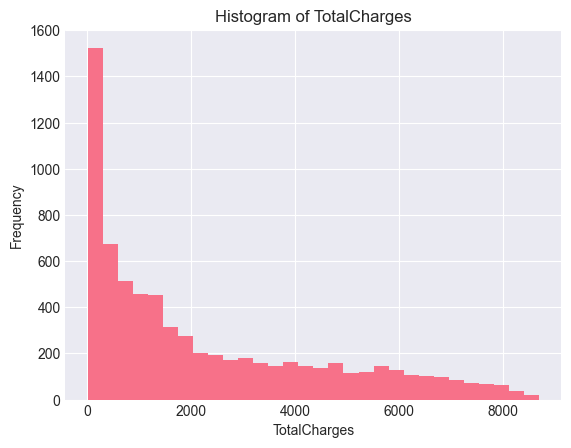

In [8]:
plt.figure()
plt.hist(df["TotalCharges"].dropna(), bins=30)
plt.xlabel("TotalCharges")
plt.ylabel("Frequency")
plt.title("Histogram of TotalCharges")
plt.show()

In [9]:
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())


In [10]:
# Quick order
num_cols = df.select_dtypes(include=['int','float']).columns.tolist()
num_cols = [c for c in num_cols if c not in ('Churn',)]
cat_cols = [c for c in df.columns if c not in num_cols + ['Churn'] + ['customerID']]
print('\nNumeric cols:', num_cols)
print('Categorical cols :', cat_cols)




Numeric cols: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical cols : ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


## 4) Feature engineering
Target: `Churn` mapped to binary 1 = yes, 0 = no. This is the dependent variable used for classification models.

In [11]:
if 'Churn' in df.columns:
    df['Churn'] = df['Churn'].map({'Yes':1,'No':0}).astype(int)

## Visualisation - Distribution - Statistics

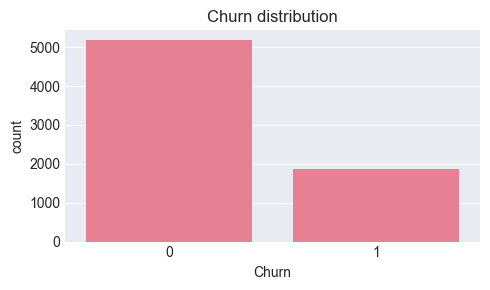

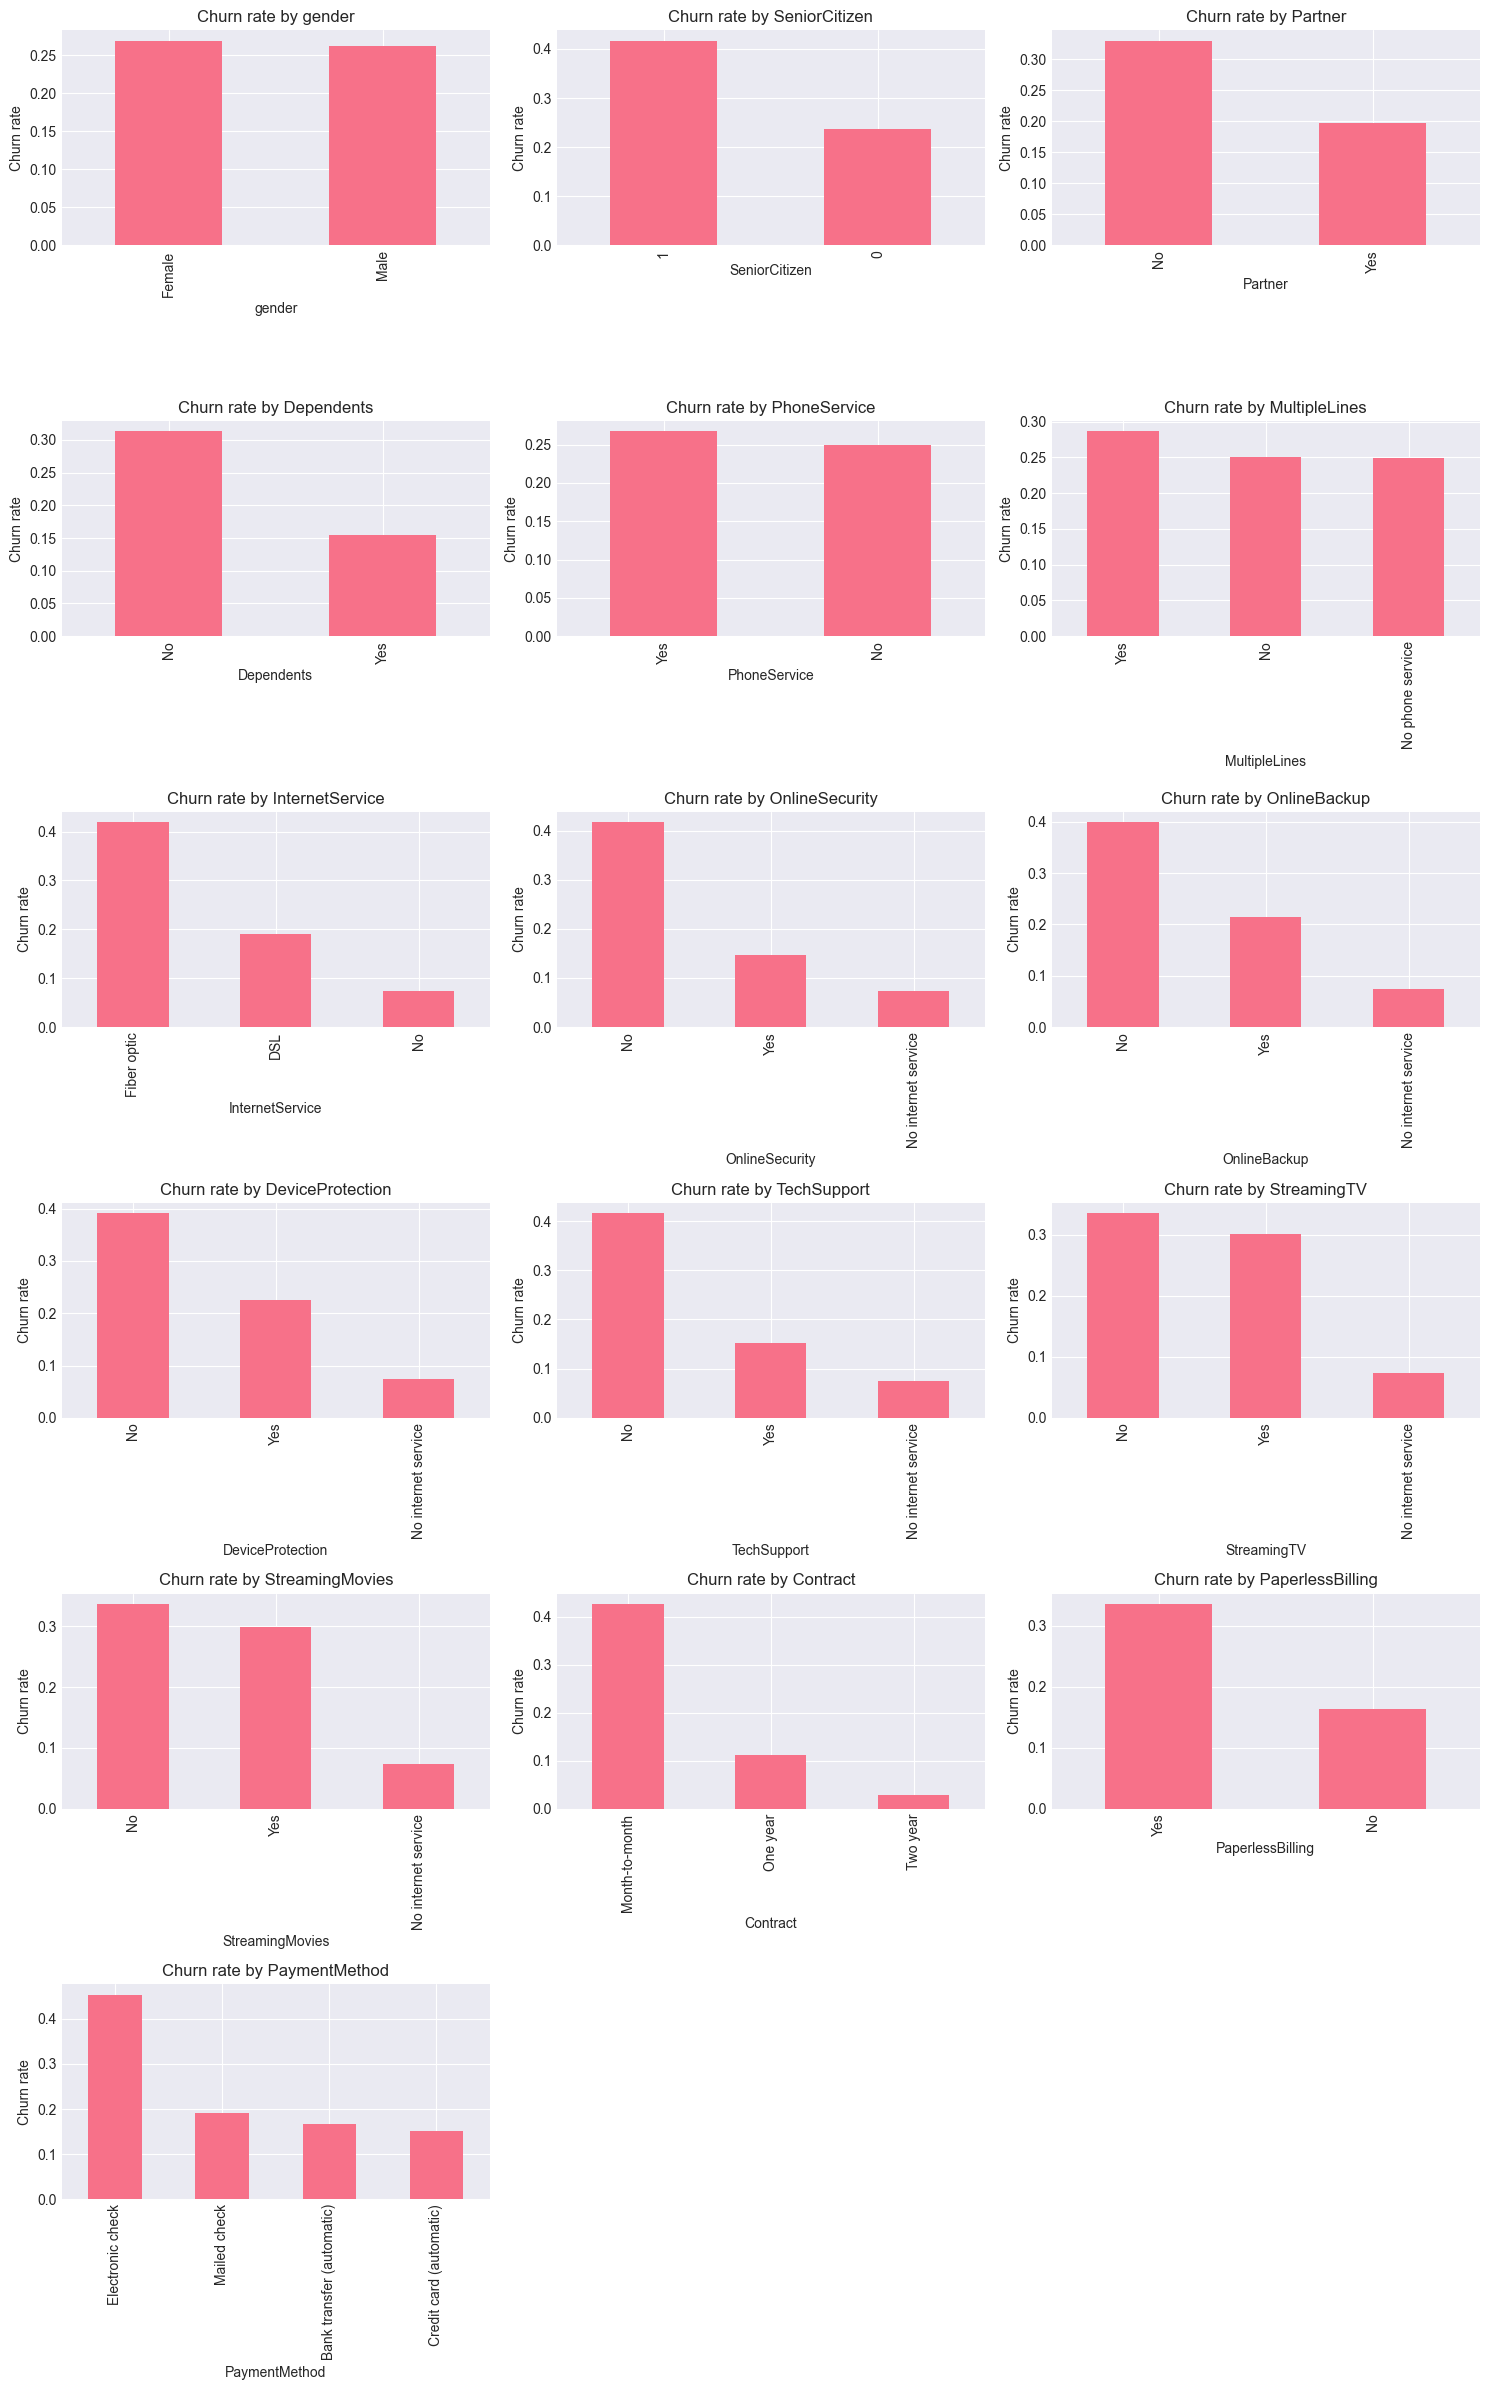

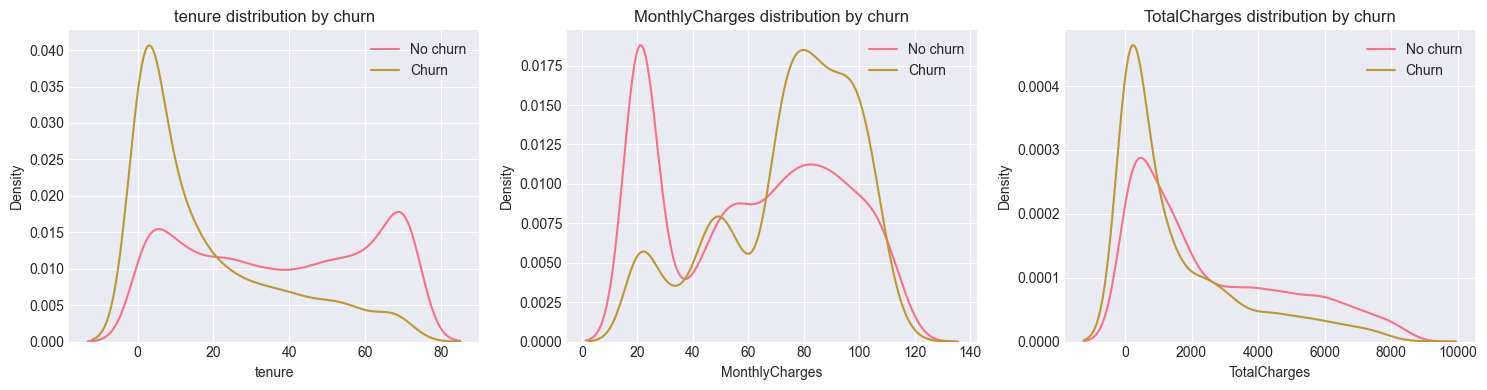

In [12]:
import math
# =========================
# 1. Churn distribution
# =========================
plt.figure(figsize=(5,3))
sns.countplot(x='Churn', data=df)
plt.title('Churn distribution')
plt.tight_layout()
plt.show()


# ==========================================
# 2. Churn rate by categorical variables
#    (3 plots per row)
# ==========================================
cat_cols = [c for c in cat_cols if c in df.columns]

n_cols = 3
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    tmp = df.groupby(col)['Churn'].mean().sort_values(ascending=False)
    tmp.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Churn rate by {col}')
    axes[i].set_ylabel('Churn rate')

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# ==========================================
# 3. Numeric distributions by churn
#    (3 plots per row)
# ==========================================
num_cols = [c for c in num_cols if c in df.columns]

n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, c in enumerate(num_cols):
    sns.kdeplot(
        df.loc[df['Churn'] == 0, c].dropna(),
        label='No churn',
        ax=axes[i]
    )
    sns.kdeplot(
        df.loc[df['Churn'] == 1, c].dropna(),
        label='Churn',
        ax=axes[i]
    )
    axes[i].set_title(f'{c} distribution by churn')
    axes[i].legend()

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [13]:
# Create a DataFrame for analysis
analysis_df = df[num_cols + cat_cols].copy()

In [14]:
# Churn relationship analysis
print("\n=== Relationship With Churn ===")

# For numeric variables
print("Moyennes par statut Churn (variables numériques):")
churn_numeric = analysis_df.groupby(df['Churn'])[num_cols].mean()
print(churn_numeric)


# For categorical variables
print("\nChurn distribution by category :")
for col in cat_cols:
    if col in analysis_df.columns:
        cross_tab = pd.crosstab(analysis_df[col], df['Churn'], normalize='index') * 100
        print(f"\n{col}:")
        print(cross_tab.round(2))


=== Relationship With Churn ===
Moyennes par statut Churn (variables numériques):
          tenure  MonthlyCharges  TotalCharges
Churn                                         
0      37.569965       61.265125   2552.882494
1      17.979133       74.441330   1531.796094

Churn distribution by category :

gender:
Churn       0      1
gender              
Female  73.08  26.92
Male    73.84  26.16

SeniorCitizen:
Churn              0      1
SeniorCitizen              
0              76.39  23.61
1              58.32  41.68

Partner:
Churn        0      1
Partner              
No       67.04  32.96
Yes      80.34  19.66

Dependents:
Churn           0      1
Dependents              
No          68.72  31.28
Yes         84.55  15.45

PhoneService:
Churn             0      1
PhoneService              
No            75.07  24.93
Yes           73.29  26.71

MultipleLines:
Churn                 0      1
MultipleLines                 
No                74.96  25.04
No phone service  75.07  24.93


In [15]:
# 4️⃣ Calcul des p-values
# -----------------------------
p_values = {}

# Variables numériques : t-test
for col in num_cols :
    group0 = df[df['Churn']==0][col]
    group1 = df[df['Churn']==1][col]
    t_stat, p_val = ttest_ind(group0, group1, nan_policy='omit')
    p_values[col] = p_val

# Variables catégorielles : Chi-2 test
for col in cat_cols:
    contingency_table = pd.crosstab(df[col], df['Churn'])
    chi2, p_val, dof, ex = chi2_contingency(contingency_table)
    p_values[col] = p_val


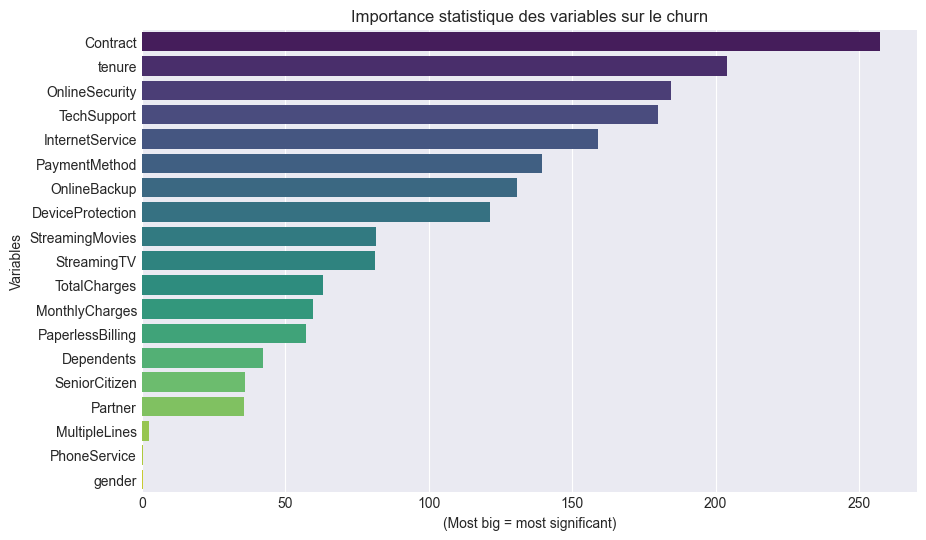

In [16]:
# 5️⃣ Transformer en DataFrame pour visualisation
# -----------------------------
pvals_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value'])
pvals_df['significant'] = pvals_df['p_value'] < 0.05
pvals_df = pvals_df.sort_values('p_value')

# Affichage graphique
plt.figure(figsize=(10,6))
sns.barplot(x=-np.log10(pvals_df['p_value']), y=pvals_df.index, palette='viridis')
plt.xlabel('(Most big = most significant)')
plt.ylabel("Variables")
plt.title("Importance statistique des variables sur le churn")
plt.show()

Another way to check the relationship with churn is to compute the t-test for numeric variable and chi-2 test for categorical variable. 

As you can see, `PhoneService` and `gender` is not significant.

## Modeling 
For predicting churn rates, a methodological approach combining interpretability and performance was adopted. 


Logistic regression was chosen because of its solid statistical foundation and excellent interpretability (Hosmer & Lemeshow, 2000). This generalized linear model allows direct inference on the impact of explanatory variables via odds ratios, thus providing an in-depth understanding of the determinants of churn.

Random Forest was chosen for its robustness and ability to capture nonlinear interactions between variables (Breiman, 2001). Based on the principle of bagging and feature randomness, this ensemble model significantly reduces the risk of overfitting while providing a reliable measure of the importance of variables.

Finally, XGBoost (Extreme Gradient Boosting) was selected for its state-of-the-art classification performance (Chen & Guestrin, 2016). This sequential boosting model iteratively minimizes the loss function by correcting the errors of previous trees, with advanced regularization mechanisms that improve generalization.

This triple approach allows us to benefit from the analytical transparency of logistic regression, the robustness of Random Forest, and the optimal predictive performance of XGBoost, thus covering all the requirements of a data science project, from exploration to operational prediction.

Références :

Breiman, L. (2001). Random Forests. Machine Learning, 45(1), 5-32.

Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining.

Hosmer, D. W., & Lemeshow, S. (2000). Applied Logistic Regression (2nd ed.). Wiley.

In [17]:
# -----------------------------
significant_cols = pvals_df[pvals_df['p_value'] < 0.05].index.tolist()
if 'Churn' in significant_cols:
    significant_cols.remove('Churn')

print("Variables retenues pour le modèle :", significant_cols)

features_for_model = significant_cols
df_model = df[features_for_model].copy()

Variables retenues pour le modèle : ['Contract', 'tenure', 'OnlineSecurity', 'TechSupport', 'InternetService', 'PaymentMethod', 'OnlineBackup', 'DeviceProtection', 'StreamingMovies', 'StreamingTV', 'TotalCharges', 'MonthlyCharges', 'PaperlessBilling', 'Dependents', 'SeniorCitizen', 'Partner', 'MultipleLines']


In [18]:
X = df.drop(columns=["Churn", "customerID"])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [19]:
# 2. Feature selection
num_features = X.select_dtypes(include=['int', 'float', 'int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print('Numerical features:', len(num_features), num_features)
print('Categorical features:', len(cat_features), cat_features[:10])

# 3. Preprocessing Pipelines 
# Vérifier s'il y a des NaN
has_nan = X.isnull().any().any()
if has_nan:
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
else:
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler())  
    ])


cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')) 
])

# 4. ColumnTransformer 
if num_features and cat_features:
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])
elif num_features:
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, num_features)
    ])
else:
    preprocessor = ColumnTransformer([
        ('cat', cat_transformer, cat_features)
    ])

print(f"\nPreprocessor configured with {len(num_features)} numeric variables and {len(cat_features)} categorical variables")

Numerical features: 3 ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: 16 ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection']

Preprocessor configured with 3 numeric variables and 16 categorical variables


In [20]:
# Fit preprocessing only on training data
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

print(X_train_pre.shape, X_test_pre.shape)


(5634, 30) (1409, 30)


In [21]:
# Get feature names after preprocessing
num_feature_names = num_features

cat_feature_names = preprocessor.named_transformers_['cat'] \
    .named_steps['ohe'] \
    .get_feature_names_out(cat_features)

feature_names = list(num_feature_names) + list(cat_feature_names)
feature_names

['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'gender_Male',
 'SeniorCitizen_1',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [22]:

X_train_df = pd.DataFrame(
    X_train_pre,
    columns=feature_names,
    index=X_train.index
)


In [23]:
# Optionnel : retirer des colonnes avant modélisation
X_train_df = X_train_df
X_test_df = pd.DataFrame(X_test_pre, columns=feature_names)

In [24]:

print(f'Train: {X_train_df.shape}, Test: {X_test_df.shape}')


models = {
    'logreg_full': LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga', random_state=42),
    'rf_default': RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42, max_depth=10)
}

# XGBoost
models['xgb_default'] = xgb.XGBClassifier(eval_metric='logloss', random_state=42,
                                          scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))


Train: (5634, 30), Test: (1409, 30)


In [25]:
# Définir CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Stocker les résultats
cv_results = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

# --- Autres modèles scikit-learn
for name, model in models.items():
    scores = cross_val_score(model, X_train_pre, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    cv_results[name] = (np.mean(scores), np.std(scores))

# --- Affichage
for name, (mean_auc, std_auc) in cv_results.items():
    print(f"{name}: mean={mean_auc:.4f}, std={std_auc:.4f}")


logreg_full: mean=0.8459, std=0.0124
rf_default: mean=0.8445, std=0.0096
xgb_default: mean=0.8220, std=0.0078


In [26]:
# On choisit le meilleur modèle selon la CV
best_model_name = 'rf_default'  # par exemple
best_model = models[best_model_name]

best_model.fit(X_train_pre, y_train)
y_pred = best_model.predict(X_test_pre)
y_proba = best_model.predict_proba(X_test_pre)[:,1]

roc = roc_auc_score(y_test, y_proba)
print(f"{best_model_name} test ROC AUC: {roc:.4f}")
print(classification_report(y_test, y_pred))


rf_default test ROC AUC: 0.8423
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.54      0.72      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409

